# Data Preprocessing of Presidential Debate 2024 (Trump vs Biden)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
# load the abcnews_transcript file from the data folder
with open('../data/cnnnews_biden_trump.txt', 'r') as file:
    data = file.read()

trumps_responses = []
bidens_responses = []

trump_identifier = "TRUMP:  "
trump_2_identifier = "DONALD TRUMP, FORMER PRESIDENT OF THE UNITED STATES AND CURRENT U.S. PRESIDENTIAL CANDIDATE: "
biden_identifier = "BIDEN: "
biden_2_identifier = "JOE BIDEN, PRESIDENT OF THE UNITED STATES: "
dana_identifier = "DANA BASH, CNN MODERATOR: "
dana_identifier2 = "BASH: "
tapper_identifier = "JAKE TAPPER, CNN MODERATOR: "
tapper_identifier2 = "TAPPER: "

current_speaker = None
idenifiers = [trump_identifier, trump_2_identifier, biden_identifier, biden_2_identifier, dana_identifier, dana_identifier2, tapper_identifier, tapper_identifier2]

for line in data.split('\n'):
    if line:
        for identifier in idenifiers:
            if line.startswith(identifier):
                current_speaker = identifier
        if current_speaker == trump_identifier or current_speaker == trump_2_identifier:
            trumps_responses.append(line)
        elif current_speaker == biden_identifier or current_speaker == biden_2_identifier:
            bidens_responses.append(line)

trump_responses = []
bucket = ""
for response in trumps_responses:
    if response.startswith(trump_identifier) or response.startswith(trump_2_identifier):
        trump_responses.append(bucket)
        bucket = ""
    bucket += response
trump_responses = trump_responses[1:]
# remove the identifiers from the responses
trump_responses = [response.replace(trump_identifier, '').replace(trump_2_identifier, '') for response in trump_responses]

biden_responses = []
bucket = ""
for response in bidens_responses:
    if response.startswith(biden_identifier) or response.startswith(biden_2_identifier):
        biden_responses.append(bucket)
        bucket = ""
    bucket += response
biden_responses = biden_responses[1:]
# remove the identifiers from the responses
biden_responses = [response.replace(biden_identifier, '').replace(biden_2_identifier, '') for response in biden_responses]

In [7]:
# load cleaned responses from the data folder for kamala kamala_responses_cleaned.txt
with open('../data/bidenBIDEN_responses_cleaned.txt', 'r') as file:
    CLN_kamala_responses = file.read()

# load cleaned responses from the data folder for trump_responses_cleaned.txt
with open('../data/trumpBIDEN_responses_cleaned.txt', 'r') as file:
    CLN_trump_responses = file.read()

In [8]:
# Download and use the mlburnham/Political_DEBATE_base_v1.0 model from the huggingface model hub
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

gpu_id = 1

with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("mlburnham/Political_DEBATE_base_v1.0")
    model = AutoModelForSequenceClassification.from_pretrained("mlburnham/Political_DEBATE_base_v1.0").to(torch.device("cuda:"+str(gpu_id)))

In [9]:
# Hypotheses
hypothesis_republican = "This text expresses Republican beliefs."
hypothesis_democrat = "This text expresses Democrat beliefs."

# Function to classify each sentence
def print_political_affiliation(sentences):
    for sentence in sentences:
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(sentence, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(sentence, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Value closer to 0 means the hypothesis is more likely
        # Value closert to 1 means the hypothesis is less likely
        # If both scores are close to 1 then the sentence is neutral
        print(f"Sentence: {sentence}")
        if republican_score < 0.5:
            print(f"--> Republican belief likely ({round(republican_score,3)}).")
        if democrat_score < 0.5:
            print(f"--> Democrat belief likely ({round(democrat_score,3)}).")
        if republican_score > 0.5 and democrat_score > 0.5:
            print("--> Neutral statement.")


In [10]:
# the following sentences are examples of political beliefs 
# the first one is a republican belief, the second one is a democrat belief and the third one is a neutral belief
test_sentences = ["I believe in lower taxes and less government intervention.", 
                    "I believe in free healthcare and education for all.", 
                    "I believe in the right to bear arms and freedom of speech."]

# Run the classification
print_political_affiliation(test_sentences)  

Sentence: I believe in lower taxes and less government intervention.
--> Republican belief likely (0.0).
Sentence: I believe in free healthcare and education for all.
--> Democrat belief likely (0.002).
Sentence: I believe in the right to bear arms and freedom of speech.
--> Republican belief likely (0.102).


In [11]:
from tqdm import tqdm
# Hypotheses
hypothesis_republican = "This text expresses Republican beliefs."
hypothesis_democrat = "This text expresses Democrat beliefs."

# Function to classify each sentence
def classify_political_affiliation(sentences):
    sentence_affiliations = {}
    for sentence in tqdm(sentences):
        # Tokenize input for both Republican and Democrat hypotheses
        inputs_republican = tokenizer(sentence, hypothesis_republican, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
        inputs_democrat = tokenizer(sentence, hypothesis_democrat, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))

        # Get logits for both hypotheses
        with torch.no_grad():
            logits_republican = model(**inputs_republican).logits
            logits_democrat = model(**inputs_democrat).logits

        # Compare the scores
        republican_score = torch.softmax(logits_republican, dim=1)[0][1].item()  # Entailment score for Republican
        democrat_score = torch.softmax(logits_democrat, dim=1)[0][1].item()      # Entailment score for Democrat

        # Enter sentence as key and scores as values
        sentence_affiliations[sentence] = []
        sentence_affiliations[sentence].append(republican_score)
        sentence_affiliations[sentence].append(democrat_score)

    return sentence_affiliations



In [17]:
trumps_affiliated_sentences = classify_political_affiliation(trump_responses)  

100%|██████████| 48/48 [00:01<00:00, 29.25it/s]


In [20]:
bidens_affiliated_sentences = classify_political_affiliation(biden_responses)

100%|██████████| 44/44 [00:01<00:00, 30.32it/s]


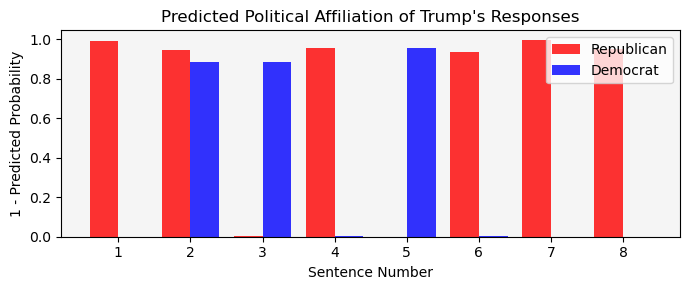

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in trumps_affiliated_sentences.items() if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
ax.set_title('Predicted Political Affiliation of Trump\'s Responses')
ax.set_xlabel('Sentence Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(np.arange(1, N + 1))
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()


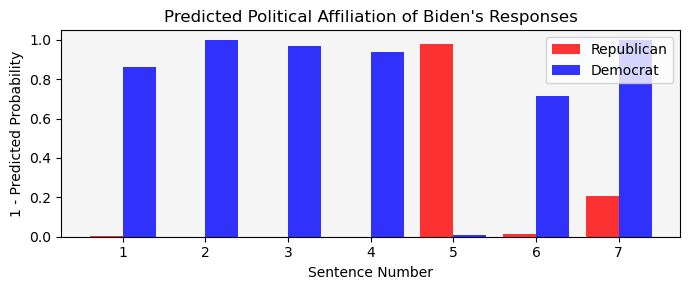

In [21]:
# Filter out sentences where neither value is smaller than 0.5
filtered_data = {k: v for k, v in bidens_affiliated_sentences.items() if v[0] < 0.5 or v[1] < 0.5}
N = len(filtered_data)
x = np.arange(1, N + 1)
republican_bars = [1 - v[0] for v in filtered_data.values()]
democrat_bars = [1 - v[1] for v in filtered_data.values()]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 3))
width = 0.4  # Width of the bars
ax.bar(x - width/2, republican_bars, width, color='red', alpha=.8, label='Republican')
ax.bar(x + width/2, democrat_bars, width, color='blue', alpha=.8, label='Democrat')
ax.set_title('Predicted Political Affiliation of Biden\'s Responses')
ax.set_xlabel('Sentence Number')
ax.set_ylabel('1 - Predicted Probability')
ax.set_xticks(x)
ax.set_xticklabels(np.arange(1, N + 1))
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

In [22]:
# Print sentences in which Harris' responses are classified as Republican
# and Trump's responses are classified as Democrat

for sentence, scores in bidens_affiliated_sentences.items():
    if scores[0] < 0.5:
        print(f"Biden Harris: {sentence}")
        print(f"Scores: {scores}")
        print("Classified as Biden saying something Republican\n")

print("\n------------------------------\n")
for sentence, scores in trumps_affiliated_sentences.items():
    if scores[1] < 0.5:
        print(f"Donald Trump: {sentence}")
        print(f"Scores: {scores}")
        print("Classified as Trump saying something Democrat\n")


Biden Harris:  The idea that veterans are not being taken care of, I told you before – and, by the way, when I said “suckers and losers,” he said – he acknowledged after it that he fired that general. That general got fired because he’s the one that acknowledged that that’s what he said. He was the one standing with Trump when he said it, number one.Number two, the idea that we’re going to be in a situation where all these millions and millions, the way he talks about it, illegal aliens are coming into the country and taking away our jobs, there’s a reason why we have the fastest-growing economy in the world, a reason why we have the most successful economy in the world. We’re doing better than any other nation in the world.And, by the way, those 15 Nobel laureates he talked about being phony, those 15 Nobel laureates, economists, they all said that, if Trump is re-elected, we’re likely to have a recession, and inflation is going to increasingly go up.And by the way, worst president in

In [23]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification
import torch
from tqdm import tqdm

gpu_id = 1

# Load the tokenizer and model
with torch.cuda.device(1):
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(torch.device("cuda:"+str(gpu_id)))

# Function to classify the sentiment of each sentence
def classify_sentiment(responses):
    sentence_sentiments = {}
    # each response can be multiple sentences
    # we want to classify the sentiment of each sentence
    # and store the average sentiment of the response 
    
    # split the responses into sentences
    for response in tqdm(responses):
        sentences = response.split(".")
        sentiment_scores = []
        for sentence in sentences:
            # Tokenize the input
            inputs = tokenizer(sentence, return_tensors="pt", truncation=True).to(torch.device("cuda:"+str(gpu_id)))
            
            # Get the logits
            with torch.no_grad():
                logits = model(**inputs).logits

            # Get the predicted sentiment
            sentiment = torch.argmax(logits, dim=1).item()
            #print(sentiment, sentence)                             # To check the sentiment of each sentence
            sentiment_scores.append(sentiment)
        
        # Store the average sentiment of the response along with the standard deviation
        sentence_sentiments[response] = (sum(sentiment_scores) / len(sentiment_scores), np.std(sentiment_scores))
        


    return sentence_sentiments

/mounts/work/pwicke/miniconda3/envs/debate/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
test_responses = [
    "I love this product. It's amazing! Highly recommended.",  # Positive
    "This is the worst experience I've ever had. Completely terrible.",  # Negative
    "The service was okay. Nothing special, but not bad either.",  # Neutral
    "I was impressed by the quality. The customer service was great too.",  # Positive
    "It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.",  # Mixed (partially positive and negative)
    #"Number one, I have nothing to do, as you know and as she knows better than anyone, I have nothing to do with Project 2025. That's out there. I haven't read it. I don't want to read it, purposely. I'm not going to read it. This was a group of people that got together, they came up with some ideas. I guess some good, some bad. But it makes no difference. I have nothing to do -- everybody knows I'm an open book. Everybody knows what I'm going to do. Cut taxes very substantially. And create a great economy like I did before. We had the greatest economy. We got hit with a pandemic. And the pandemic was, not since 1917 where 100 million people died has there been anything like it? We did a phenomenal job with the pandemic. We handed them over a country where the economy and where the stock market was higher than it was before the pandemic came in. Nobody's ever seen anything like it. We made ventilators for the entire world. We got gowns. We got masks. We did things that nobody thought possible. And people give me credit for rebuilding the military. They give me credit for a lot of things. But not enough credit for the great job we did with the pandemic. But the only jobs they got were bounce-back jobs. These were jobs, bounce back. And it bounced back and it went to their benefit. But I was the one that created them. They know it and so does everybody else."
]

# Assuming classify_sentiment function is defined as shown before
test_sentiments = classify_sentiment(test_responses)

# Print the results to verify
for response, sentiment in test_sentiments.items():
    print(f"Response: '{response}'")
    print(f"Average Sentiment Score: {sentiment}")
    print("-" * 50)

100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

Response: 'I love this product. It's amazing! Highly recommended.'
Average Sentiment Score: (1.6666666666666667, 0.4714045207910317)
--------------------------------------------------
Response: 'This is the worst experience I've ever had. Completely terrible.'
Average Sentiment Score: (0.3333333333333333, 0.4714045207910317)
--------------------------------------------------
Response: 'The service was okay. Nothing special, but not bad either.'
Average Sentiment Score: (1.6666666666666667, 0.4714045207910317)
--------------------------------------------------
Response: 'I was impressed by the quality. The customer service was great too.'
Average Sentiment Score: (1.6666666666666667, 0.4714045207910317)
--------------------------------------------------
Response: 'It's an average product. The delivery was slow, and the packaging was damaged. But it works fine.'
Average Sentiment Score: (0.75, 0.82915619758885)
--------------------------------------------------


In [25]:
# We need the indices of the responses through the entire debate
indexed_responses = {idx: line for idx, line in enumerate(data.split('\n'))}

### TODO: This does not work

In [26]:
trumps_sentiments = classify_sentiment(trump_responses)
bidens_sentiments = classify_sentiment(biden_responses)

100%|██████████| 44/44 [00:03<00:00, 12.71it/s]


In [27]:
# Print sentiments of the first 5 responses and sentences
for sentence, sentiment in trumps_sentiments.items():
    print(sentiment, sentence)



(1.0, 0.816496580927726) We had the greatest economy in the history of our country. We had never done so well. Every – everybody was amazed by it. Other countries were copying us.We got hit with COVID. And when we did, we spent the money necessary so we wouldn’t end up in a Great Depression the likes of which we had in 1929. By the time we finished – so we did a great job. We got a lot of credit for the economy, a lot of credit for the military, and no wars and so many other things. Everything was rocking good.But the thing we never got the credit for, and we should have, is getting us out of that COVID mess. He created mandates; that was a disaster for our country.But other than that, we had – we had given them back a – a country where the stock market actually was higher than pre-COVID, and nobody thought that was even possible. The only jobs he created are for illegal immigrants and bounceback jobs; they’re bounced back from the COVID.He has not done a good job. He’s done a poor job

In [29]:
indexed_sentiments = {}
for idx, response in indexed_responses.items():
    if not response:
        continue
    response = response.split(": ")[1]
    if response in trumps_sentiments:
        indexed_sentiments[idx] = "T", trumps_sentiments[response]
    elif response in bidens_sentiments:
        indexed_sentiments[idx] = "H", bidens_sentiments[response]


IndexError: list index out of range

In [18]:
indexed_sentiments

{18: ('H', (1.3333333333333333, 0.4714045207910317)),
 20: ('T', (1.6666666666666667, 0.4714045207910317)),
 22: ('T', (1.5, 0.5)),
 24: ('T', (1.5, 0.5)),
 32: ('H', (1.263157894736842, 0.6359497880839249)),
 36: ('T', (0.6052631578947368, 0.6299320633466223)),
 40: ('H', (0.75, 0.82915619758885)),
 44: ('T', (1.0, 0.6324555320336759)),
 48: ('H', (0.7, 0.7810249675906655)),
 50: ('T', (1.0, 0.6793662204867574)),
 54: ('T', (0.3333333333333333, 0.4714045207910317)),
 58: ('H', (0.9, 0.7000000000000001)),
 62: ('T', (0.52, 0.64)),
 68: ('T', (1.0, 0.6324555320336759)),
 70: ('T', (0.7272727272727273, 0.4453617714151233)),
 72: ('T', (1.2608695652173914, 0.5289358721998452)),
 76: ('H', (0.42857142857142855, 0.49487165930539345)),
 78: ('H', (0.8181818181818182, 0.5749595745760689)),
 82: ('T', (0.8666666666666667, 0.6182412330330469)),
 86: ('T', (0.47368421052631576, 0.49930699897395464)),
 90: ('T', (0.6428571428571429, 0.6102859818083952)),
 94: ('H', (0.5384615384615384, 0.63432394

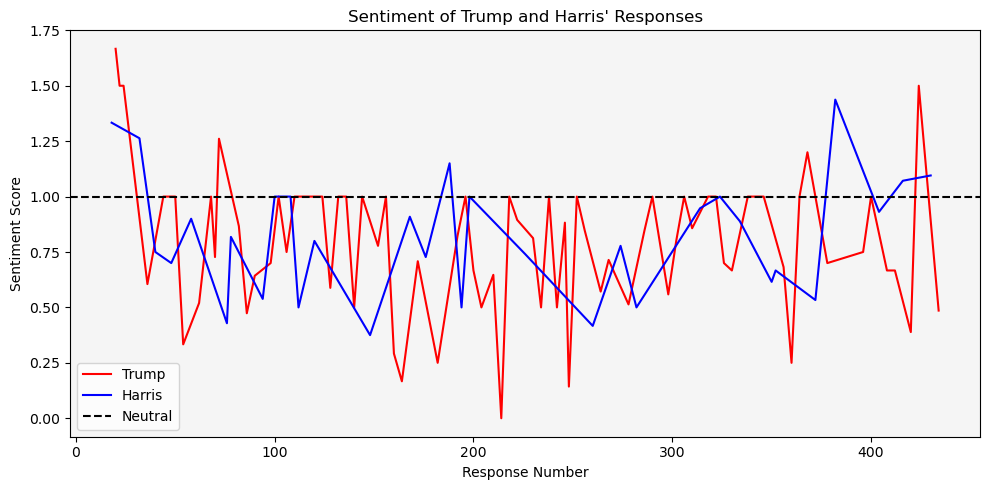

In [19]:
# Plot the indexed sentiments 
# Use a red line for Trump's responses and a blue line for Harris' responses
# Use the indexed sentiments with the idices for the x axis
# The sentiment score will be the y axis
import matplotlib.pyplot as plt

trump_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
trump_sentiments = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "T"]
harris_indices = [idx for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]
harris_sentiments = [sentiment[1][0] for idx, sentiment in indexed_sentiments.items() if sentiment[0] == "H"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_sentiments, color='red', label="Trump")
ax.plot(harris_indices, harris_sentiments, color='blue', label="Harris")
# line at 1 for neutral
ax.axhline(1, color='black', linestyle='--', label='Neutral')
ax.set_title("Sentiment of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Sentiment Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()


# Use WordNet to check Specificity

In [20]:
import nltk
from nltk.corpus import wordnet as wn
import string
from nltk.corpus import stopwords

nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_word(word):
    word = word.strip(string.punctuation).lower()
    if '\'' in word:
        word = word.split('\'')[0]
    return word

def get_clean_word_specificity(word):
    word_clean = clean_word(word)
    if word_clean in stop_words:
        return 0
    synsets = wn.synsets(word_clean)
    if not synsets:
        print(f"Word '{word_clean}' not found in WordNet")
        return 0  # Word not found in WordNet
    max_depth = max([synset.max_depth() for synset in synsets])
    #print(clean_word(word), max_depth)
    return max_depth

def get_word_specificity(word):
    synsets = wn.synsets(word)
    if not synsets:
        print(f"Word '{word}' not found in WordNet")
        return 0  # Word not found in WordNet
    max_depth = max([synset.max_depth() for synset in synsets])
    #print(clean_word(word), max_depth)
    return max_depth

def missing_in_wordnet(word):
    synsets = wn.synsets(word)
    if not synsets:
        #print(f"Word '{word}' not found in WordNet")
        return 1  
    else:
        return 0


# Example words
word1 = "dog"
word2 = "animal"

specificity1 = get_word_specificity(word1)
specificity2 = get_word_specificity(word2)

print(f"Specificity of '{word1}': {specificity1}")
print(f"Specificity of '{word2}': {specificity2}")


[nltk_data] Downloading package wordnet to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Specificity of 'dog': 13
Specificity of 'animal': 6


In [21]:
# For CLN_kamala_responses and CLN_trump_responses break
# the responses at the \n character to get individual sentences

CLN_kamala_sentences = CLN_kamala_responses.split("\n")
CLN_trump_sentences = CLN_trump_responses.split("\n")



In [22]:
# Assume trumps_responses is a list of sentences
# Ensure trumps_specificity is a dictionary where each response has associated word specificity scores

#trumps_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in trumps_responses}
#harris_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in kamalas_responses}

trumps_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in CLN_trump_sentences}
harris_specificity = {response: [get_word_specificity(word) for word in response.split()] for response in CLN_kamala_sentences}
    

# Function to calculate the average specificity of each response
def calculate_average_specificity(responses):
    return {response: (sum(specificities) / len(specificities)) if specificities else 0 
            for response, specificities in responses.items()}

# Calculate the average specificity for Trump's responses
trumps_avg_specificity = calculate_average_specificity(trumps_specificity)
harris_avg_specificity = calculate_average_specificity(harris_specificity)


Word 'would' not found in WordNet
Word 'everything' not found in WordNet
Word 'Biden' not found in WordNet
Word 'anyone' not found in WordNet
Word 'everybody' not found in WordNet
Word 'everybody' not found in WordNet
Word 'since' not found in WordNet
Word 'anything' not found in WordNet
Word 'anything' not found in WordNet
Word 'everybody' not found in WordNet
Word 'else' not found in WordNet
Word 'Biden' not found in WordNet
Word 'anything' not found in WordNet
Word 'else' not found in WordNet
Word 'everything' not found in WordNet
Word 'MAGA' not found in WordNet
Word 'everybody' not found in WordNet
Word 'something' not found in WordNet
Word 'Ronald' not found in WordNet
Word 'could' not found in WordNet
Word 'would' not found in WordNet
Word 'everybody' not found in WordNet
Word 'everybody' not found in WordNet
Word 'else' not found in WordNet
Word 'something' not found in WordNet
Word 'would' not found in WordNet
Word 'JD' not found in WordNet
Word 'JD' not found in WordNet
Word 

In [23]:
# List all unique words in the CLN_trump_sentences and CLN_kamala_sentences
unique_words_trump = set()
for response in CLN_trump_sentences:
    unique_words_trump.update(response.split())

unique_words_harris = set()
for response in CLN_kamala_sentences:
    unique_words_harris.update(response.split())

# Evaluate how many percentage of the unique words are missing in WordNet
missing_trump = sum([missing_in_wordnet(word) for word in unique_words_trump])
missing_harris = sum([missing_in_wordnet(word) for word in unique_words_harris])

print(f"Percentage of unique words in Trump's responses missing in WordNet: {missing_trump / len(unique_words_trump) * 100:.2f}%")
print(f"Percentage of unique words in Harris' responses missing in WordNet: {missing_harris / len(unique_words_harris) * 100:.2f}%")


Percentage of unique words in Trump's responses missing in WordNet: 5.65%
Percentage of unique words in Harris' responses missing in WordNet: 4.76%


In [24]:
def aggregate_specificity(responses_avg_specificity):
    return sum(responses_avg_specificity.values()) / len(responses_avg_specificity)

# Aggregating specificity scores
trumps_aggregate_specificity = aggregate_specificity(trumps_avg_specificity)
harris_aggregate_specificity = aggregate_specificity(harris_avg_specificity)

print(f"Trump's Aggregate Specificity: {trumps_aggregate_specificity}")
print(f"Harris' Aggregate Specificity: {harris_aggregate_specificity}")


Trump's Aggregate Specificity: 7.098870534052228
Harris' Aggregate Specificity: 6.888268671445486


In [25]:
# List Trump's top 5 responses with the highest average specificity
trumps_top_specificity = sorted(trumps_avg_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
print("Trump's Top 5 Responses with Highest Average Specificity:")
for response, avg_specificity in trumps_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

print("-" * 50)

# List Harris' top 5 responses with the highest average specificity
harris_top_specificity = sorted(harris_avg_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
print("Harris' Top 5 Responses with Highest Average Specificity:")
for response, avg_specificity in harris_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

Trump's Top 5 Responses with Highest Average Specificity:
Response: 'David one thing'
Average Specificity: 10.666666666666666
--------------------------------------------------
Response: 'throw campaign like dog even know president president'
Average Specificity: 10.0
--------------------------------------------------
Response: 'find'
Average Specificity: 9.0
--------------------------------------------------
--------------------------------------------------
Harris' Top 5 Responses with Highest Average Specificity:
Response: 'lie lie audible'
Average Specificity: 10.666666666666666
--------------------------------------------------
Response: 'get get president time invite Taliban Camp David place storied significance Americans place honor importance american diplomacy invite receive respected world leader former president president invite Camp David appreciate role responsibility President United States commander chief level respect get back point consistently disparage demean member 

In [26]:
# List Trump's top 5 responses with the lowest average specificity
trumps_top_specificity = sorted(trumps_avg_specificity.items(), key=lambda x: x[1], reverse=False)[:3]
print("Trump's Top 5 Responses with Lowest Average Specificity:")
for response, avg_specificity in trumps_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

print("-" * 50)

# List Harris' top 5 responses with the lowest average specificity
harris_top_specificity = sorted(harris_avg_specificity.items(), key=lambda x: x[1], reverse=False)[:3]
print("Harris' Top 5 Responses with Lowest Average Specificity:")
for response, avg_specificity in harris_top_specificity:
    print(f"Response: '{response}'")
    print(f"Average Specificity: {avg_specificity}")
    print("-" * 50)

Trump's Top 5 Responses with Lowest Average Specificity:
Response: ''
Average Specificity: 0
--------------------------------------------------
Response: 'respond'
Average Specificity: 2.0
--------------------------------------------------
Response: 'know alive'
Average Specificity: 3.5
--------------------------------------------------
--------------------------------------------------
Harris' Top 5 Responses with Lowest Average Specificity:
Response: 'inaudible'
Average Specificity: 0.0
--------------------------------------------------
Response: ''
Average Specificity: 0
--------------------------------------------------
Response: 'true'
Average Specificity: 6.0
--------------------------------------------------


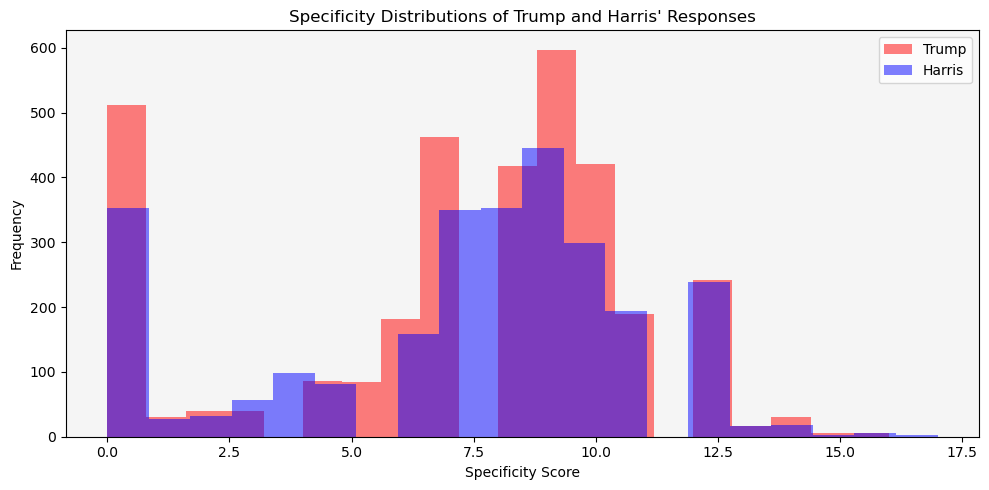

In [27]:
import matplotlib.pyplot as plt

# Plot distributions of specificity scores for each word in Trump's responses and Harris' responses
# Put both into one plot with different colors for each distribution (trump in red, harris in blue)


# Function to plot the specificity distributions
def plot_specificity_distributions(trumps_specificity, harris_specificity):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(trumps_specificity, bins=20, color='red', alpha=0.5, label="Trump")
    ax.hist(harris_specificity, bins=20, color='blue', alpha=0.5, label="Harris")
    ax.set_title("Specificity Distributions of Trump and Harris' Responses")
    ax.set_xlabel("Specificity Score")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.set_facecolor('whitesmoke')
    plt.tight_layout()
    plt.show()

# Extract the specificity scores for each word in Trump's responses and Harris' responses
trumps_specificity_scores = [score for response in trumps_specificity.values() for score in response]
harris_specificity_scores = [score for response in harris_specificity.values() for score in response]

# Plot the distributions
plot_specificity_distributions(trumps_specificity_scores, harris_specificity_scores)



In [28]:
from scipy.stats import ttest_ind

# Perform t-test to compare means
t_stat, p_value = ttest_ind(list(trumps_avg_specificity.values()), 
                            list(harris_avg_specificity.values()))
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 0.6077063422118184, P-value: 0.5446820228336348


# Using Bolognesi Data to check Specificity

In [29]:
# Loading Bolognesi from data/Bolognesi_Data.csv
# without pandas
with open('../data/Bolognesi_Data.csv', 'r') as file:
    bolognesi_data = file.read()
    
# Split the data into lines
bolognesi_lines = bolognesi_data.split('\n')


In [30]:
# Turn the data into a dictionary
# Drop the header
# Store the first column as the key and the other columns as list of values 
# for this list, we only store the first and the last column
bolognesi_dict = {}
for line in bolognesi_lines[1:]:
    if not line:
        continue
    columns = line.split(',')
    bolognesi_dict[columns[0]] = [float(columns[1]), float(columns[-1])]

# Print the first 5 entries in the dictionary
for key, value in list(bolognesi_dict.items())[:5]:
    print(f"{key}: {value}")

entirety: [3.07, 1.8571428571428572]
creationism: [1.69, 2.0]
thousand: [3.08, 2.0]
flashback: [2.36, 2.428571428571429]
organist: [4.0, 2.571428571428571]


In [31]:
CLN_trump_all_responses = CLN_trump_responses.replace("\n", " ")
CLN_kamala_all_responses = CLN_kamala_responses.replace("\n", " ")

# Check how many of the words in all trump and kamala responses are in the Bolognesi dictionary
trump_words = set(CLN_trump_all_responses.split())
kamala_words = set(CLN_kamala_all_responses.split())

trump_bolognesi_words = trump_words.intersection(bolognesi_dict.keys())
kamala_bolognesi_words = kamala_words.intersection(bolognesi_dict.keys())

print(f"Number of words in Trump's responses found in Bolognesi dictionary: {len(trump_bolognesi_words)}")
print(f"Number of words in Kamala's responses found in Bolognesi dictionary: {len(kamala_bolognesi_words)}")

# Print number of unique words in Trump's responses
print(f"Number of unique words in Trump's responses: {len(trump_words)}")
# Print number of unique words in Kamala's responses
print(f"Number of unique words in Kamala's responses: {len(kamala_words)}")

Number of words in Trump's responses found in Bolognesi dictionary: 293
Number of words in Kamala's responses found in Bolognesi dictionary: 379
Number of unique words in Trump's responses: 867
Number of unique words in Kamala's responses: 924


In [32]:
# Load nltk pos tagger
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Now check how many of the words in all trump and kamala responses are NOUNS
trump_nouns = set()
kamala_nouns = set()

for word in trump_words:
    tokens = nltk.word_tokenize(word)  # Tokenize the word
    pos = nltk.pos_tag(tokens)[0][1]   # Tag the first (and only) token
    if pos.startswith('N'):            # Check if it's a noun
        trump_nouns.add(word)

for word in kamala_words:
    tokens = nltk.word_tokenize(word)  # Tokenize the word
    pos = nltk.pos_tag(tokens)[0][1]   # Tag the first (and only) token
    if pos.startswith('N'):            # Check if it's a noun
        kamala_nouns.add(word)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [33]:
# Check how many nouns of trump and harris responses are in the Bolognesi dictionary
trump_nouns_bolognesi = trump_nouns.intersection(bolognesi_dict.keys())
kamala_nouns_bolognesi = kamala_nouns.intersection(bolognesi_dict.keys())

# Express this in percentage
trump_nouns_bolognesi_percentage = len(trump_nouns_bolognesi) / len(trump_nouns) * 100
kamala_nouns_bolognesi_percentage = len(kamala_nouns_bolognesi) / len(kamala_nouns) * 100

print(f"Percentage of nouns in Trump's responses found in Bolognesi dictionary: {trump_nouns_bolognesi_percentage:.2f}%")
print(f"Percentage of nouns in Kamala's responses found in Bolognesi dictionary: {kamala_nouns_bolognesi_percentage:.2f}%")

Percentage of nouns in Trump's responses found in Bolognesi dictionary: 45.79%
Percentage of nouns in Kamala's responses found in Bolognesi dictionary: 52.49%


In [34]:
# The second value in the Bolognesi dictionary is the specificity score
# Calculate the average specificity of nouns in Trump's responses
trump_nouns_specificity = [bolognesi_dict[word][1] for word in trump_nouns_bolognesi]
trump_nouns_avg_specificity = sum(trump_nouns_specificity) / len(trump_nouns_specificity)

# Calculate the average specificity of nouns in Kamala's responses
kamala_nouns_specificity = [bolognesi_dict[word][1] for word in kamala_nouns_bolognesi]
kamala_nouns_avg_specificity = sum(kamala_nouns_specificity) / len(kamala_nouns_specificity)

print(f"Average Specificity of nouns in Trump's responses based on Bolognesi data: {round(trump_nouns_avg_specificity,3)}")
print(f"Average Specificity of nouns in Kamala's responses based on Bolognesi data: {round(kamala_nouns_avg_specificity,3)}")

Average Specificity of nouns in Trump's responses based on Bolognesi data: 2.063
Average Specificity of nouns in Kamala's responses based on Bolognesi data: 2.034


In [35]:
# The first value in the Bolognesi dictionary is the concreteness score
# Calculate the average concreteness of nouns in Trump's responses
trump_nouns_concreteness = [bolognesi_dict[word][0] for word in trump_nouns_bolognesi]
trump_nouns_avg_concreteness = sum(trump_nouns_concreteness) / len(trump_nouns_concreteness)

# Calculate the average concreteness of nouns in Kamala's responses
kamala_nouns_concreteness = [bolognesi_dict[word][0] for word in kamala_nouns_bolognesi]
kamala_nouns_avg_concreteness = sum(kamala_nouns_concreteness) / len(kamala_nouns_concreteness)

print(f"Average Concreteness of nouns in Trump's responses based on Bolognesi data: {round(trump_nouns_avg_concreteness,3)}")
print(f"Average Concreteness of nouns in Kamala's responses based on Bolognesi data: {round(kamala_nouns_avg_concreteness,3)}")


Average Concreteness of nouns in Trump's responses based on Bolognesi data: 3.534
Average Concreteness of nouns in Kamala's responses based on Bolognesi data: 3.317


In [36]:
# Plot CLN_trump_all_responses with the specificity and concreteness of nouns

# First, get rid off all words in CLN_trump_all_responses that are not in the Bolognesi dictionary
clean_trump_bolognesi_responses = []
clean_harris_bolognesi_responses = []

for response in CLN_trump_responses.split("\n"):
    temp = []
    for word in response.split(" "):
        if word in bolognesi_dict:
            temp.append(word)
    if temp:
        clean_trump_bolognesi_responses.append(temp)

for response in CLN_kamala_responses.split("\n"):
    temp = []
    for word in response.split(" "):
        if word in bolognesi_dict:
            temp.append(word)
    if temp:
        clean_harris_bolognesi_responses.append(temp)
    
clean_trump_bolognesi_responses[:2]

[['fun'],
 ['sale',
  'tax',
  'statement',
  'tariff',
  'country',
  'country',
  'year',
  'world',
  'tariff',
  'case',
  'billion',
  'billion',
  'dollar',
  'fact',
  'tariff',
  'money',
  'billion',
  'dollar',
  'place',
  'tariff',
  'tariff',
  'inflation',
  'economy',
  'inflation',
  'country',
  'buster',
  'country',
  'inflation',
  'people',
  'nation',
  'history',
  'thing',
  'year',
  'disaster',
  'people',
  'middle',
  'class',
  'class',
  'top',
  'million',
  'people',
  'country',
  'prison',
  'jail',
  'institution',
  'asylum',
  'job',
  'union',
  'union',
  'town',
  'town',
  'building',
  'people',
  'country',
  'country',
  'level',
  'criminality',
  'economy',
  'history',
  'country']]

In [37]:
# How many responses are left?
print(f"Number of Trump responses left after cleaning: {len(clean_trump_bolognesi_responses)}")
print(f"Number of Harris responses left after cleaning: {len(clean_harris_bolognesi_responses)}")
# How many before?
print(f"Number of Trump responses before cleaning: {len(CLN_trump_responses.split())}")
print(f"Number of Harris responses before cleaning: {len(CLN_kamala_responses.split())}")


Number of Trump responses left after cleaning: 65
Number of Harris responses left after cleaning: 28
Number of Trump responses before cleaning: 3361
Number of Harris responses before cleaning: 2735


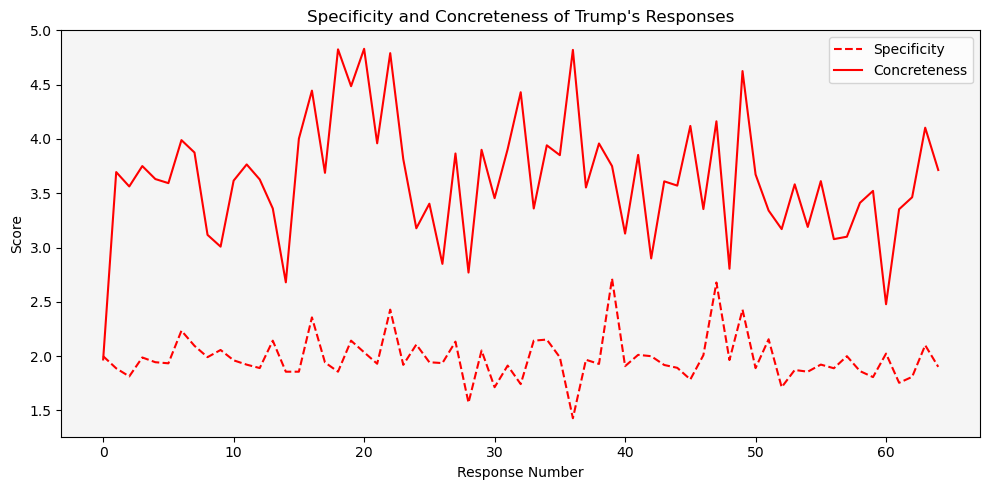

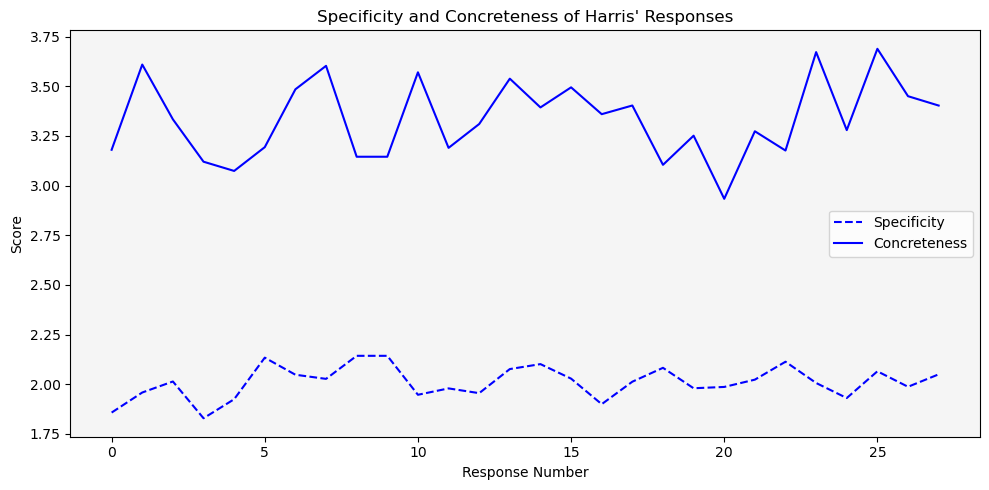

In [38]:
# For each response, calculate the average specificity and concreteness
trump_avg_specificity = []
trump_avg_concreteness = []
harris_avg_specificity = []
harris_avg_concreteness = []

for response in clean_trump_bolognesi_responses:
    specificity = [bolognesi_dict[word][1] for word in response]
    concreteness = [bolognesi_dict[word][0] for word in response]
    trump_avg_specificity.append(sum(specificity) / len(specificity))
    trump_avg_concreteness.append(sum(concreteness) / len(concreteness))

for response in clean_harris_bolognesi_responses:
    specificity = [bolognesi_dict[word][1] for word in response]
    concreteness = [bolognesi_dict[word][0] for word in response]
    harris_avg_specificity.append(sum(specificity) / len(specificity))
    harris_avg_concreteness.append(sum(concreteness) / len(concreteness))

# Plot both the average specificity and concreteness over the responses
# a dotted line for specificity and a solid line for concreteness
# a red line for Trump and a blue line for Harris
# one plot for each candidate

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_avg_specificity, color='red', linestyle='--', label="Specificity")
ax.plot(trump_avg_concreteness, color='red', label="Concreteness")
ax.set_title("Specificity and Concreteness of Trump's Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(harris_avg_specificity, color='blue', linestyle='--', label="Specificity")
ax.plot(harris_avg_concreteness, color='blue', label="Concreteness")
ax.set_title("Specificity and Concreteness of Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()




### Aligning both responses via index

In [39]:
import spacy
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')


trump_indexed_concreteness = {}
trump_indexed_specificity = {}
harris_indexed_concreteness = {}
harris_indexed_specificity = {}

for idx, response in indexed_responses.items():
    if not response:
        continue
    if response.startswith("FORMER PRESIDENT DONALD TRUMP: "):
        response = response.split(": ")[1]
        
        # Cleaning
        response = response.replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '')
        doc = nlp(response)
        response_cleaned = ' '.join([token.lemma_ for token in doc if token.is_alpha])
        response_cleaned = ' '.join([word for word in response_cleaned.split() if word.lower() not in stop_words])
        
        # add the concreteness score for each word in the response up
        concreteness = 0
        specificity = 0
        for word in response_cleaned.split():
            if word in bolognesi_dict:
                concreteness += bolognesi_dict[word][0]
                specificity += bolognesi_dict[word][1]
        # add average concreteness score for the response
        trump_indexed_concreteness[idx] = concreteness / len(response_cleaned.split())
        trump_indexed_specificity[idx] = specificity / len(response_cleaned.split())

    elif response.startswith("VICE PRESIDENT KAMALA HARRIS: "):
        response = response.split(": ")[1]
        
        # Cleaning
        response = response.replace('.', '').replace(',', '').replace('--', '').replace('\'re', '').replace('\'m', '')
        doc = nlp(response)
        response_cleaned = ' '.join([token.lemma_ for token in doc if token.is_alpha])
        response_cleaned = ' '.join([word for word in response_cleaned.split() if word.lower() not in stop_words])
        
        # add the concreteness score for each word in the response up
        concreteness = 0
        specificity = 0
        for word in response_cleaned.split():
            if word in bolognesi_dict:
                concreteness += bolognesi_dict[word][0]
                specificity += bolognesi_dict[word][1]
        # add average concreteness score for the response
        harris_indexed_concreteness[idx] = concreteness / len(response_cleaned.split())
        harris_indexed_specificity[idx] = specificity / len(response_cleaned.split())
        
        

[nltk_data] Downloading package stopwords to
[nltk_data]     /mounts/Users/cisintern/pwicke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


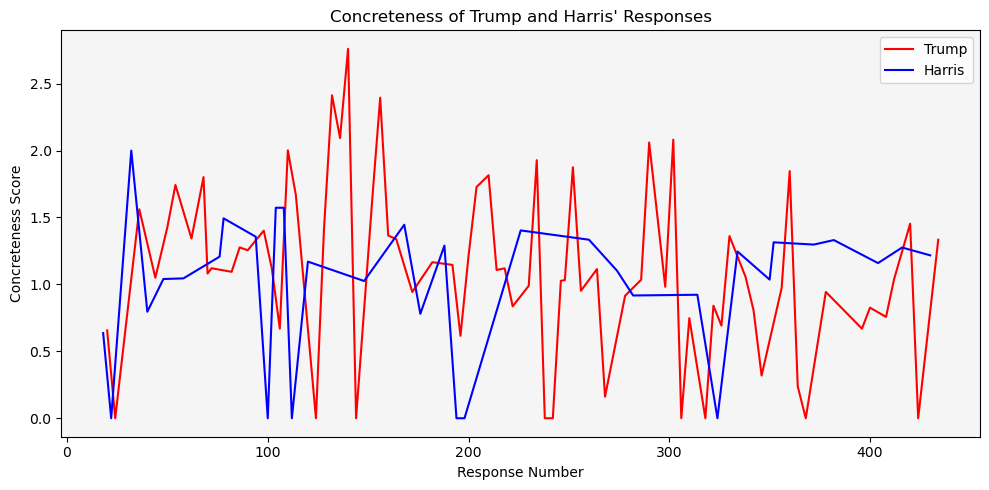

In [40]:
# Plot the concreteness scores for Trump and Harris for each response in the debate
# Do it in one plot with a red line for Trump and a blue line for Harris
# Use the indexed concreteness scores with the idices for the x axis
# The concreteness score will be the y axis

trump_indices = [idx for idx, concreteness in trump_indexed_concreteness.items()]
trump_concreteness = [concreteness for idx, concreteness in trump_indexed_concreteness.items()]
harris_indices = [idx for idx, concreteness in harris_indexed_concreteness.items()]
harris_concreteness = [concreteness for idx, concreteness in harris_indexed_concreteness.items()]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_concreteness, color='red', label="Trump")
ax.plot(harris_indices, harris_concreteness, color='blue', label="Harris")
ax.set_title("Concreteness of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Concreteness Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()


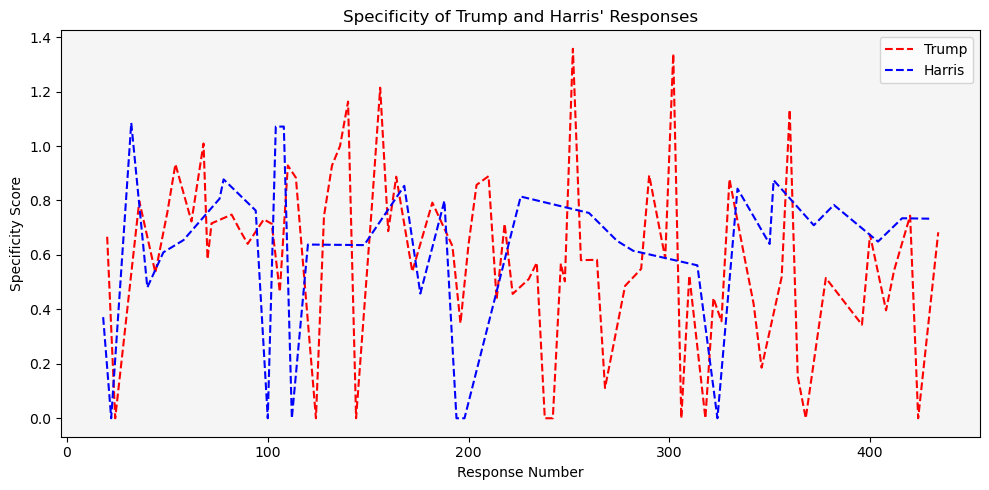

In [41]:
# Plot the concreteness scores for Trump and Harris for each response in the debate
# Do it in one plot with a red line for Trump and a blue line for Harris
# Use the indexed concreteness scores with the idices for the x axis
# The concreteness score will be the y axis

trump_indices = [idx for idx, specificity in trump_indexed_specificity.items()]
trump_specificity = [specificity for idx, specificity in trump_indexed_specificity.items()]
harris_indices = [idx for idx, specificity in harris_indexed_specificity.items()]
harris_specificity = [specificity for idx, specificity in harris_indexed_specificity.items()]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(trump_indices, trump_specificity, color='red', linestyle='--', label="Trump")
ax.plot(harris_indices, harris_specificity, color='blue', linestyle='--', label="Harris")
ax.set_title("Specificity of Trump and Harris' Responses")
ax.set_xlabel("Response Number")
ax.set_ylabel("Specificity Score")
ax.legend()
ax.set_facecolor('whitesmoke')
plt.tight_layout()
plt.show()

In [42]:
# Print some of the responses with the highest and lowest concreteness scores
# For both candidates to see if the concreteness score makes sense
trump_highest_concreteness = sorted(trump_indexed_concreteness.items(), key=lambda x: x[1], reverse=True)[:3]
trump_lowest_concreteness = sorted(trump_indexed_concreteness.items(), key=lambda x: x[1], reverse=False)[:3]
harris_highest_concreteness = sorted(harris_indexed_concreteness.items(), key=lambda x: x[1], reverse=True)[:3]
harris_lowest_concreteness = sorted(harris_indexed_concreteness.items(), key=lambda x: x[1], reverse=False)[:3]

print("Trump's Responses with Highest Concreteness:")
for idx, concreteness in trump_highest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)

print("Trump's Responses with Lowest Concreteness:")
for idx, concreteness in trump_lowest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Highest Concreteness:")
for idx, concreteness in harris_highest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Lowest Concreteness:")
for idx, concreteness in harris_lowest_concreteness:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Concreteness: {concreteness}")
    print("-" * 50)
print("-" * 50)

Trump's Responses with Highest Concreteness:
Response 140: FORMER PRESIDENT DONALD TRUMP: But the people on television say their dog was eaten by the people that went there.
Concreteness: 2.7600000000000002
--------------------------------------------------
Response 132: FORMER PRESIDENT DONALD TRUMP: Well, I've seen people on television
Concreteness: 2.4125
--------------------------------------------------
Response 156: FORMER PRESIDENT DONALD TRUMP: With local police.
Concreteness: 2.395
--------------------------------------------------
--------------------------------------------------
Trump's Responses with Lowest Concreteness:
Response 24: FORMER PRESIDENT DONALD TRUMP: Thank you.
Concreteness: 0.0
--------------------------------------------------
Response 124: FORMER PRESIDENT DONALD TRUMP: Well, I would like to respond.
Concreteness: 0.0
--------------------------------------------------
Response 144: FORMER PRESIDENT DONALD TRUMP: We'll find out
Concreteness: 0.0
-----------

In [43]:
# Print some of the responses with the highest and lowest specificity scores
# For both candidates to see if the specificity score makes sense
trump_highest_specificity = sorted(trump_indexed_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
trump_lowest_specificity = sorted(trump_indexed_specificity.items(), key=lambda x: x[1], reverse=False)[:3]
harris_highest_specificity = sorted(harris_indexed_specificity.items(), key=lambda x: x[1], reverse=True)[:3]
harris_lowest_specificity = sorted(harris_indexed_specificity.items(), key=lambda x: x[1], reverse=False)[:3]

print("Trump's Responses with Highest Specificity:")
for idx, specificity in trump_highest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)

print("Trump's Responses with Lowest Specificity:")
for idx, specificity in trump_lowest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Highest Specificity:")
for idx, specificity in harris_highest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)
print("Harris' Responses with Lowest Specificity:")
for idx, specificity in harris_lowest_specificity:
    print(f"Response {idx}: {indexed_responses[idx]}")
    print(f"Specificity: {specificity}")
    print("-" * 50)
print("-" * 50)




Trump's Responses with Highest Specificity:
Response 252: FORMER PRESIDENT DONALD TRUMP: No judge looked at it.
Specificity: 1.3571428571428572
--------------------------------------------------
Response 302: FORMER PRESIDENT DONALD TRUMP: They threw him out of a campaign like a dog. We don't even know, is he our president? But we have a president...
Specificity: 1.3392857142857144
--------------------------------------------------
Response 156: FORMER PRESIDENT DONALD TRUMP: With local police.
Specificity: 1.2142857142857144
--------------------------------------------------
--------------------------------------------------
Trump's Responses with Lowest Specificity:
Response 24: FORMER PRESIDENT DONALD TRUMP: Thank you.
Specificity: 0.0
--------------------------------------------------
Response 124: FORMER PRESIDENT DONALD TRUMP: Well, I would like to respond.
Specificity: 0.0
--------------------------------------------------
Response 144: FORMER PRESIDENT DONALD TRUMP: We'll find 